In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
DATA_PATH = 'data/'
JOB_POSTINGS_PATH = DATA_PATH + 'gsearch_jobs.csv'
COMPANIES_PATH = DATA_PATH + 'companies.csv'
INDUSTRIES_PATH = DATA_PATH + 'industries.csv'
COMPANY_INDUSTRY_PATH = DATA_PATH + 'company_industries.csv'
EMPLOYEE_COUNTS_PATH = DATA_PATH + 'employee_counts.csv'
JOB_LEVEL_VERIFY_PATH = DATA_PATH + 'verify_job_level_extraction.csv'
PROCESSED_DATA_PATH = DATA_PATH + 'dataframe_after_preprocessing.csv'

In [3]:
df_merged = pd.read_csv(PROCESSED_DATA_PATH)

In [4]:
df_merged.columns

Index(['title', 'company_name', 'location_0', 'location_1', 'location_2',
       'location_3', 'location_4', 'location_5', 'location_6', 'location_7',
       'via', 'description', 'extensions', 'job_id', 'thumbnail', 'posted_at',
       'schedule_type', 'work_from_home', 'salary', 'search_term', 'date_time',
       'search_location', 'commute_time', 'salary_pay', 'salary_rate',
       'salary_avg', 'salary_min', 'salary_max', 'salary_hourly',
       'salary_yearly', 'salary_standardized', 'description_tokens',
       'company_id', 'name', 'company_description', 'company_size', 'state',
       'country', 'city', 'zip_code', 'address', 'url', 'industry_0',
       'industry_1', 'industry_2', 'industry_3', 'industry_4', 'industry_5',
       'industry_6', 'Years_of_Experience', 'job_level', 'average_length',
       'num_skills', 'required_soft_skills'],
      dtype='object')

### Classification Model

Accuracy:  0.7325170411512244
Confusion Matrix: 
 [[2926 1033]
 [1086 2877]]
Classification Report: 
               precision    recall  f1-score   support

        high       0.73      0.74      0.73      3959
         low       0.74      0.73      0.73      3963

    accuracy                           0.73      7922
   macro avg       0.73      0.73      0.73      7922
weighted avg       0.73      0.73      0.73      7922



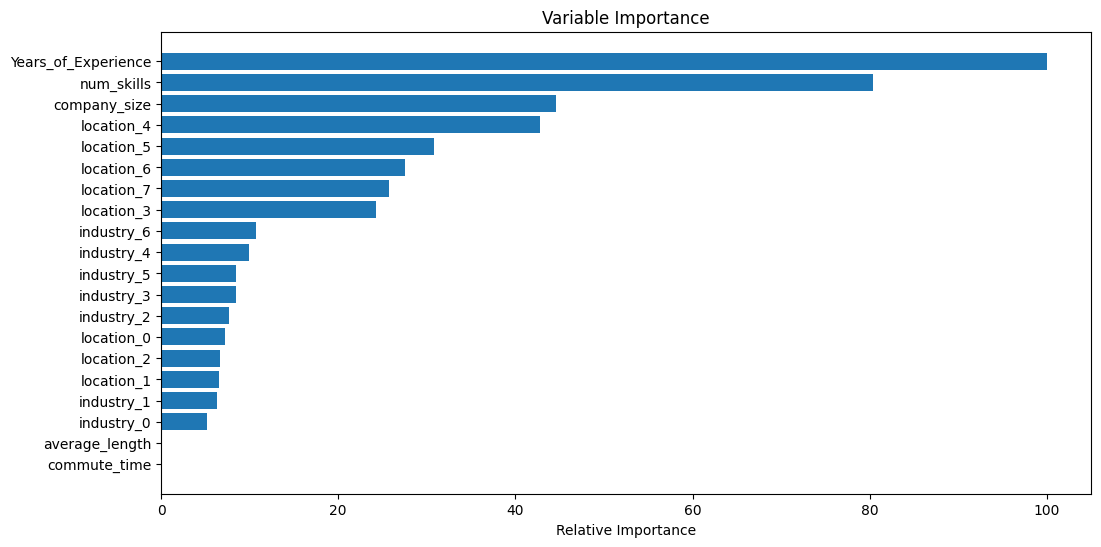

In [6]:
# Categorize salary into high and low according to the median
df_merged['salary_category'] = np.where(df_merged['salary_standardized'] > df_merged['salary_standardized'].median(), 'high', 'low')

# fit the model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X = df_merged[['location_0', 'location_1', 'location_2','location_3', 'location_4', 'location_5', 
               'location_6', 'location_7','commute_time', 'company_size', 'industry_0',
               'industry_1', 'industry_2', 'industry_3', 'industry_4', 'industry_5',
               'industry_6', 'Years_of_Experience', 'average_length', 'num_skills']].fillna(0)
y = df_merged['salary_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification Report: \n', classification_report(y_test, y_pred))

# Feature importance
feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
# Try multiple models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

models = [LogisticRegression(), SVC(), GradientBoostingClassifier(), KNeighborsClassifier(), GaussianNB(), MLPClassifier()]
model_names = ['Logistic Regression', 'SVM', 'Gradient Boosting', 'KNN', 'Naive Bayes', 'Neural Network']
accuracy_list = []

for model, model_name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model_name)
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
    print('Classification Report: \n', classification_report(y_test, y_pred))
    print('\n')

d:\anaconda\envs\si699\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Accuracy:  0.6658672052511992
Confusion Matrix: 
 [[2637 1322]
 [1325 2638]]
Classification Report: 
               precision    recall  f1-score   support

        high       0.67      0.67      0.67      3959
         low       0.67      0.67      0.67      3963

    accuracy                           0.67      7922
   macro avg       0.67      0.67      0.67      7922
weighted avg       0.67      0.67      0.67      7922



SVM
Accuracy:  0.5002524614996213
Confusion Matrix: 
 [[   0 3959]
 [   0 3963]]
Classification Report: 
               precision    recall  f1-score   support

        high       0.00      0.00      0.00      3959
         low       0.50      1.00      0.67      3963

    accuracy                           0.50      7922
   macro avg       0.25      0.50      0.33      7922
weighted avg       0.25      0.50      0.33      7922





d:\anaconda\envs\si699\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\envs\si699\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\envs\si699\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Gradient Boosting
Accuracy:  0.7150971976773542
Confusion Matrix: 
 [[2950 1009]
 [1248 2715]]
Classification Report: 
               precision    recall  f1-score   support

        high       0.70      0.75      0.72      3959
         low       0.73      0.69      0.71      3963

    accuracy                           0.72      7922
   macro avg       0.72      0.72      0.71      7922
weighted avg       0.72      0.72      0.71      7922



KNN
Accuracy:  0.6937642009593536
Confusion Matrix: 
 [[2815 1144]
 [1282 2681]]
Classification Report: 
               precision    recall  f1-score   support

        high       0.69      0.71      0.70      3959
         low       0.70      0.68      0.69      3963

    accuracy                           0.69      7922
   macro avg       0.69      0.69      0.69      7922
weighted avg       0.69      0.69      0.69      7922



Naive Bayes
Accuracy:  0.6062862913405705
Confusion Matrix: 
 [[3637  322]
 [2797 1166]]
Classification Report: 
   

### Best Model: Random Forest Classifier

### Baseline Linear Regression

In [22]:
for item in eval(df_merged['required_soft_skills'][0]):
    print(item)

collaboration
leadership
innovation
sales
organizational skills
critical thinking


In [27]:
from collections import Counter
all_skills = []
for i in range(len(df_merged)):
    for skill in eval(df_merged['required_soft_skills'][i]):
        all_skills.append(skill)
skill_counts = Counter(all_skills)
skill_counts_df = pd.DataFrame(skill_counts.items(), columns=['Skill', 'Count'])
skill_counts_df = skill_counts_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
print(skill_counts_df.head(20))


                     Skill  Count
0               management  19951
1                 research  10178
2               operations   8726
3               leadership   8425
4                 planning   5947
5            collaboration   5720
6                    sales   5541
7               innovation   5204
8                  writing   5047
9              integration   4768
10              governance   4268
11       analytical skills   4217
12           presentations   4146
13   written communication   3483
14              consulting   3390
15  information technology   3003
16        microsoft office   2876
17         decision making   2813
18         problem solving   2798
19          infrastructure   2693


In [28]:
import statsmodels.api as sm 
x2 = sm.add_constant(df_merged['Years_of_Experience'].fillna(0))
model = sm.OLS(df_merged['salary_standardized'], x2).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     salary_standardized   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                 -0.000
Method:                  Least Squares   F-statistic:                    0.1351
Date:                 Fri, 08 Nov 2024   Prob (F-statistic):              0.713
Time:                         22:59:54   Log-Likelihood:            -4.5032e+05
No. Observations:                39372   AIC:                         9.006e+05
Df Residuals:                    39370   BIC:                         9.007e+05
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                9.2

In [6]:
X = df_merged[['location_0', 'location_1', 'location_2','location_3', 'location_4', 'location_5', 
               'location_6', 'location_7','commute_time', 'company_size', 'industry_0',
               'industry_1', 'industry_2', 'industry_3', 'industry_4', 'industry_5',
               'industry_6', 'Years_of_Experience', 'average_length', 'num_skills']].fillna(0)
y = df_merged['salary_standardized']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=699)

import statsmodels.api as sm 
x2 = sm.add_constant(X_train)
model = sm.OLS(y_train, x2).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     salary_standardized   R-squared:                       0.081
Model:                             OLS   Adj. R-squared:                  0.081
Method:                  Least Squares   F-statistic:                     145.8
Date:                 Fri, 08 Nov 2024   Prob (F-statistic):               0.00
Time:                         15:02:28   Log-Likelihood:            -3.3874e+05
No. Observations:                29705   AIC:                         6.775e+05
Df Residuals:                    29686   BIC:                         6.777e+05
Df Model:                           18                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
location_0           1.7

In [9]:
y_pred = model.predict(X_test)

In [10]:
from sklearn.metrics import accuracy_score, mean_squared_error

# Calculate MSE (for regression or if needed as a performance metric)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 463014506.8836307


In [8]:
# %pip install transformers

In [9]:
# %pip install torch

In [ ]:
# build a BERT model for job descriptions
from transformers import BertTokenizer, BertModel
import torch
    
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
if torch.cuda.is_available():
    print ('cuda')
else:
    print('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Tokenize the job descriptions
batch_size = 16
embeddings = []

for i in range(0, len(df_merged), batch_size):
    batch_texts = df_merged['description'].tolist()[i:i+batch_size]
    encoded_inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')
    input_ids = encoded_inputs['input_ids'].to(device)
    attention_mask = encoded_inputs['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(batch_embeddings)

embeddings = np.vstack(embeddings)

d:\anaconda\envs\si699\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [ ]:
bert_embeddings_df = pd.DataFrame(embeddings, index=df_merged.index)

X_combined = pd.concat([X, bert_embeddings_df], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=699)

x2 = sm.add_constant(X_train)
model = sm.OLS(y_train, x2).fit()
print(model.summary())

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                             OLS Regression Results                            
Dep. Variable:     salary_standardized   R-squared:                       0.180
Model:                             OLS   Adj. R-squared:                  0.158
Method:                  Least Squares   F-statistic:                     8.072
Date:                 Tue, 05 Nov 2024   Prob (F-statistic):               0.00
Time:                         00:00:47   Log-Likelihood:            -3.3705e+05
No. Observations:                29705   AIC:                         6.757e+05
Df Residuals:                    28918   BIC:                         6.822e+05
Df Model:                          786                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
location_0           950

In [11]:
df_merged['description_tokens']

0                        ['tableau', 'python', 'sql', 'r']
1                                                       []
2                      ['power_bi', 'excel', 'powerpoint']
3               ['excel', 'powerpoint', 'word', 'outlook']
4        ['redshift', 'aws', 'excel', 'python', 'mysql'...
                               ...                        
39602                                              ['sql']
39603    ['snowflake', 'excel', 'python', 'tableau', 'r...
39604                                                   []
39605                                                   []
39606                                                   []
Name: description_tokens, Length: 39607, dtype: object

### Model 1

In [11]:
df_merged['description_tokens'] = df_merged['description_tokens'].apply(lambda x: re.findall(r"'(.*?)'", x))

In [26]:
from gensim.models import Word2Vec

vector_size = 10

all_tokens = [token for sublist in df_merged['description_tokens'] for token in sublist]
w2v_model1 = Word2Vec(sentences=df_merged['description_tokens'], vector_size=vector_size, window=5, min_count=1, workers=4)
w2v_model1.train(df_merged['description_tokens'], total_examples=w2v_model1.corpus_count, epochs=10)

(369150, 1295520)

In [27]:
wv = w2v_model1.wv
#After filtering for min frequency, there are 5514 words in the corpus
words = list(wv.key_to_index)
print('Vocabulary size:%d' % len(words))

Vocabulary size:133


In [18]:
wv.most_similar('r')

[('power_bi', 0.7499566078186035),
 ('sas', 0.7066496014595032),
 ('nosql', 0.702068567276001),
 ('tableau', 0.6724769473075867),
 ('sql', 0.5968387126922607),
 ('nuix', 0.595941424369812),
 ('python', 0.5951347947120667),
 ('tensorflow', 0.5462804436683655),
 ('vba', 0.5369216203689575),
 ('matlab', 0.5343853831291199)]

In [19]:
# Generate Word2Vec embeddings for job descriptions
def get_w2v_embeddings(tokens, model, vector_size=vector_size):
    embeddings = np.zeros(vector_size)
    count = 0
    for token in tokens:
        if token in model.wv:
            embeddings += model.wv[token]
            count += 1
    if count > 0:
        embeddings /= count
    return embeddings

w2v_embeddings = df_merged['description_tokens'].apply(lambda x: get_w2v_embeddings(x, w2v_model1))

# Convert the embeddings to a DataFrame
w2v_embeddings_df = pd.DataFrame(w2v_embeddings.tolist(), index=df_merged.index)

X = df_merged[['Years_of_Experience', 'average_length']].fillna(0)


# Combine the original features with the Word2Vec embeddings
X_combined_w2v = pd.concat([X, w2v_embeddings_df], axis=1)

# Split the data into training and testing sets
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_combined_w2v, y, test_size=0.25, random_state=699)

# Fit the regression model
x2_w2v = sm.add_constant(X_train_w2v)
model_w2v = sm.OLS(y_train_w2v, x2_w2v).fit()
print(model_w2v.summary())

                             OLS Regression Results                            
Dep. Variable:     salary_standardized   R-squared:                       0.018
Model:                             OLS   Adj. R-squared:                  0.018
Method:                  Least Squares   F-statistic:                     50.09
Date:                 Fri, 08 Nov 2024   Prob (F-statistic):          4.72e-110
Time:                         15:05:02   Log-Likelihood:            -3.3972e+05
No. Observations:                29705   AIC:                         6.795e+05
Df Residuals:                    29693   BIC:                         6.796e+05
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Years_of_Experience    -

In [ ]:
# Random Forest Regressor, support vector machine, and gradient boosting regressor using pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Ensure all column names are strings
X_train_w2v.columns = X_train_w2v.columns.astype(str)
X_test_w2v.columns = X_test_w2v.columns.astype(str)

# Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=699)
rf_pipeline = Pipeline([('scaler', StandardScaler()), ('rf', rf_regressor)])
rf_pipeline.fit(X_train_w2v, y_train_w2v)
rf_mse = mean_squared_error(y_test_w2v, rf_pipeline.predict(X_test_w2v))
print("Random Forest MSE:", rf_mse)

Random Forest MSE: 495497407.8575147


In [22]:
# Support Vector Machine Regressor
svr_regressor = SVR()
svr_pipeline = Pipeline([('scaler', StandardScaler()), ('svr', svr_regressor)])
svr_pipeline.fit(X_train_w2v, y_train_w2v)
svr_mse = mean_squared_error(y_test_w2v, svr_pipeline.predict(X_test_w2v))
print("SVM MSE:", svr_mse)

SVM MSE: 531521723.5875322


In [23]:
# Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=699)
gb_pipeline = Pipeline([('scaler', StandardScaler()), ('gb', gb_regressor)])
gb_pipeline.fit(X_train_w2v, y_train_w2v)
gb_mse = mean_squared_error(y_test_w2v, gb_pipeline.predict(X_test_w2v))
print("Gradient Boosting MSE:", gb_mse)

Gradient Boosting MSE: 486522135.47065854
